In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
laptops_df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')

In [14]:
laptops_df.columns = laptops_df.columns.str.lower().str.replace(' ', '_')


In [15]:
laptops_df = laptops_df[['ram', 'storage', 'screen', 'final_price']]


<Axes: xlabel='final_price', ylabel='Count'>

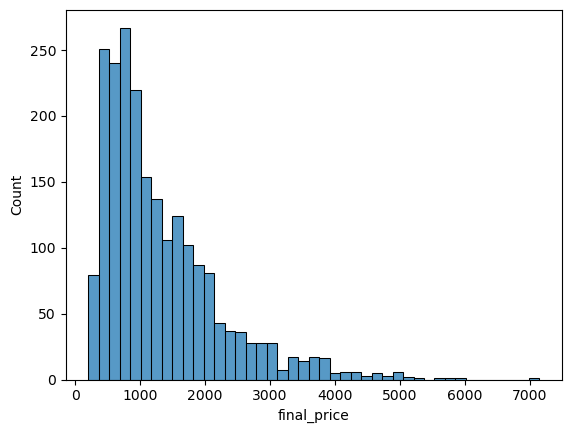

In [16]:
sns.histplot(laptops_df['final_price'])

In [17]:
laptops_df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [18]:
laptops_df['ram'].median()

16.0

In [19]:
len(laptops_df)

2160

In [20]:
np.random.seed(42)

n = len(laptops_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = laptops_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [21]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [22]:
df_train.isnull().sum()

ram        0
storage    0
screen     3
dtype: int64

## Linear Regression

In [23]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [24]:
base = ['ram', 'storage', 'screen']

In [25]:
def prepare_X(df, mean = None):
    df_num = df[base]
    df_num = df_num.fillna(0)
    if mean:
        df_num = df_num.fillna(mean)
    X = df_num.values
    
    return X

In [26]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train_orig)

In [27]:
y_pred = w_0 + X_train.dot(w)

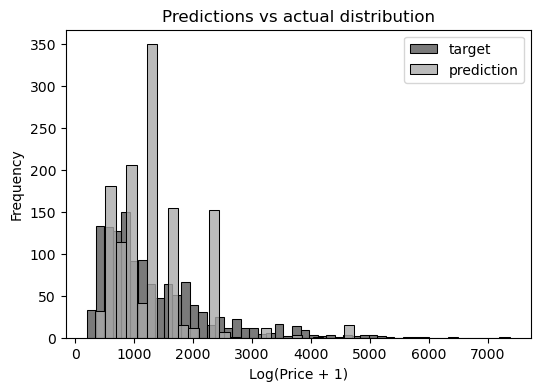

In [28]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train_orig, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [29]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [30]:
rmse(y_train_orig, y_pred)

602.3920520606714

In [31]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val_orig, y_pred)

597.3635593619636

## Regularization

In [32]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [33]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [35]:
for r in [0, 0.01, 1, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 0.4288635315474399
  0.01 0.428851636053407
     1 0.43059329897431
    10 0.5075657769236755
   100 0.6735026061726037


### CHECKING THE RMSE SCORES:

In [40]:

rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    df_shuffled = laptops_df.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val)
    y_reg_val = w_0 + X_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)

print(round(np.std(rmse_list), 3))
     

0 547.5696230193458 565.45
1 594.4197428009816 636.8
2 649.4685454776857 588.96
3 571.9459040120524 597.81
4 629.3882030653069 571.96
5 580.7647373338308 573.24
6 783.768368991956 647.34
7 376.43586006318003 550.44
8 572.8852361205966 587.33
9 663.3792792620178 576.1
29.176


In [44]:
idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

df_shuffled = laptops_df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_concat = pd.concat([df_train, df_val])

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_concat = df_concat.reset_index(drop=True)

y_test = df_test.final_price.values
y_concat = df_concat.final_price.values

del df_test['final_price']
del df_concat['final_price']

X_concat = prepare_X(df_concat)
w_0, w = train_linear_regression_reg(X_concat, y_concat, r=0.001)

X_test = prepare_X(df_test)
y_reg_test = w_0 + X_test.dot(w)
rmse_test = np.round(rmse(y_test, y_reg_test),2)

In [45]:
rmse_test

608.61